In [2]:
import os
import dill as pickle

# picklefile is the location of the pickled file generated using preader 

# below could be use to import relative to current directory if easier
# cwd = os.getcwd()
# picklefile = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\testfiles\\D2TestFiles\\Concatenated\\newpickletest5.pickle'
picklefile = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\IVDWFiles\\NoVDW\\NoVDW_cat.pickle'
# print(cwd)

# This opens the pickled file generated by preader, 
# should read in multiple files if preader prcoessed multiple output files at once 
readers = []   
with open(picklefile,'rb') as f:
     readers = pickle.load(f)

In [3]:
# this is useful to see what information is included within a reader
#dir(readers)

In [4]:
# This reads in information from PDielec and turns it into struct (pymatgen) and atoms (ASE) formats
import PDielec.UnitCell as UnitCell
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.io.ase import AseAtomsAdaptor


struct_start = Structure(readers.unit_cells[0].lattice, readers.unit_cells[0].element_names, readers.unit_cells[0].fractional_coordinates)
atoms_start  = AseAtomsAdaptor.get_atoms(struct_start)
struct_end = Structure(readers.unit_cells[-1].lattice, readers.unit_cells[-1].element_names, readers.unit_cells[-1].fractional_coordinates)
atoms_end  = AseAtomsAdaptor.get_atoms(struct_end)

In [5]:
# This uses the structure matcher tool in pymatgen to provide RMS comparison of the two structures
import numpy as np
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.structure_matcher import StructureMatcher


m = StructureMatcher()

#this is a true false statement to determine if structures map onto each other
print(m.fit(struct_start, struct_end))

# outputs a tuple of two values (avg_rms, max_rms) 
# min_rms is the minimum rms distance, see below
# min_mapping is the corresponding minimal species mapping that would map struct1 to struct2 - I dont think so, not according
# to https://pymatgen.org/pymatgen.analysis.structure_matcher.html
print(m.get_rms_dist(struct_start, struct_end))

True
(0.07601216770836378, 0.14905212551135566)


In [6]:
# This uses matminer, I had to install from source as current pip version is missing some files
# calculting the fingerprints is slow so I've left in a seperate cell to comment out
# Journal article where this is all discussed is found here 10.1039/c9ra07755c
# This will be useful for comparing structures from different dispersion corrections

from matminer.featurizers.site import CrystalNNFingerprint
from matminer.featurizers.structure import SiteStatsFingerprint


# This generates a fingerprint for each structure 
# all stats options are 'mean', 'std_dev', 'minimum', 'maximum'
ssf = SiteStatsFingerprint(CrystalNNFingerprint.from_preset('ops', distance_cutoffs=None),stats=('mean', 'maximum'))
v_s1 = np.array(ssf.featurize(struct_start))
v_s2 = np.array(ssf.featurize(struct_end))

In [7]:
print(v_s1)

[4.28819792e-01 8.77957011e-01 4.28819792e-01 8.77957011e-01
 2.73999426e-01 7.09572192e-01 5.24165519e-02 1.84180800e-01
 1.79194165e-01 5.55818426e-01 1.52050362e-01 6.83081228e-01
 4.70919064e-02 2.87035780e-01 5.26094208e-02 3.53940136e-01
 1.14325221e-01 5.50235787e-01 5.80493453e-02 3.23811835e-01
 8.60822654e-02 5.47604034e-01 2.56021641e-02 1.65720508e-01
 9.89935003e-02 3.66581234e-01 1.67850062e-02 1.18963379e-01
 8.89337963e-02 2.99451886e-01 9.87397011e-03 9.01850916e-02
 3.20406583e-02 1.86927026e-01 3.15049346e-02 1.88840959e-01
 1.45284649e-02 4.06271590e-02 4.28846968e-03 1.19445381e-02
 5.05390198e-03 1.80500660e-02 6.27580558e-03 1.74409856e-02
 1.29537107e-02 5.47065641e-02 4.57136854e-03 1.61361448e-02
 5.36551763e-03 1.81789899e-02 4.84720642e-03 1.69777310e-02
 1.27683033e-02 3.94466886e-02 4.99867894e-03 1.57830609e-02
 5.84334657e-03 2.53114926e-02 8.63919561e-03 4.95923110e-02
 8.55207812e-04 6.01677249e-03 4.08957642e-03 3.14467021e-02
 6.70496448e-03 3.801186

In [8]:
#There are a number of ways to deterine a (dis-)similarity.
#Elucidian similarity is probably what we want
#Cosine similarity would be useful as normalised between 0 and 1 however out structures maybe too similar


#A small distance value indicates high similarity between two structures, whereas a large distance (>1) suggests that the structures are very dissimilar.  (0.9). Anything beyond 0.9 is most certainly not the same structure prototype.
print('Euclidean distance between starting structure and final structure: {:.4f}'.format(np.linalg.norm(v_s1 - v_s2)))
#The Euclidean distance is simply the square root of the squared differences between corresponding elements of the rows (or columns).

# square root of dot product
print('square root of Dot product between starting structure and final structure: {:.4f}'.format(np.dot(v_s1, v_s2) ** 0.5))

#Cosine Similarity is normlised between 1, identical structure and 0 completely different
print('Cosine Similarity between starting structure and final structure: {:.4f}'.format(np.dot(v_s1, v_s2)/(np.linalg.norm(v_s1)*np.linalg.norm(v_s2))))

#Modified Cosine Similarity is normlised between 1, identical structure and 0 completely different
print('Modified Cosine Similarity between starting structure and final structure: {:.4f}'.format(np.dot(v_s1, v_s2)/np.maximum(np.linalg.norm(v_s1),np.linalg.norm(v_s2)) ** 2))

Euclidean distance between starting structure and final structure: 0.3069
square root of Dot product between starting structure and final structure: 2.2143
Cosine Similarity between starting structure and final structure: 0.9919
Modified Cosine Similarity between starting structure and final structure: 0.9403


In [9]:
# This cell produces pymatgen.site objects in a dataframe for the start and end structures
from PDielec.Constants import covalent_radii
# start_end_list = [0, -1 ]
# for k in start_end_list:
    
oldcell = readers.unit_cells[-1]
atom_masses = readers.masses
oldcell.set_atomic_masses(atom_masses)
bond_scale = 1.1
tolerance = 0.1

newcell, nmols, temp = oldcell.calculate_molecular_contents(bond_scale, tolerance, covalent_radii)

#     print(nmols)

newcell.cartesian_coordinates = newcell.convert_abc_to_xyz(newcell.fractional_coordinates)

from pymatgen.io.ase import AseAtomsAdaptor
import pandas as pd

# if k == 0:
data = {"Molecules":[],"Atoms":[]};
for i in range(nmols):
    elements = [newcell.element_names[j] for j in newcell.molecules[i]]
    positions = [newcell.cartesian_coordinates[j] for j in newcell.molecules[i]]
    molecule = Molecule(elements, positions)
    atom = AseAtomsAdaptor.get_atoms(molecule)
    data["Molecules"].append(molecule)
    data["Atoms"].append(atom)
Moleculesdf = pd.DataFrame(data)
display(Moleculesdf)
display(Moleculesdf.at[0,"Molecules"])
# else:
# data_end = {"Molecules":[],"Atoms":[]};
# for i in range(nmols):
#     elements = [newcell.element_names[j] for j in newcell.molecules[i]]
#     positions = [newcell.cartesian_coordinates[j] for j in newcell.molecules[i]]
#     molecule = Molecule(elements, positions)
#     atom = AseAtomsAdaptor.get_atoms(molecule)
#     data_end["Molecules"].append(molecule)
#     data_end["Atoms"].append(atom)
# Moleculesdf_end = pd.DataFrame(data_end)
# display(Moleculesdf_end)
# display(Moleculesdf_end.at[0,"Molecules"])




,Molecules,Atoms
0,"[[ 1.71210341 21.21512908 5.50092578] H, [ 0....","(Atom('H', [1.7121034134689863, 21.21512908487..."
1,"[[ 2.98694049 10.25193542 0.95104055] H, [ 3....","(Atom('H', [2.986940491692981, 10.251935423378..."
2,"[[3.18599035 5.04771682 4.09078677] H, [2.9623...","(Atom('H', [3.185990346850275, 5.0477168206108..."
3,"[[ 1.51305356 16.01091048 2.36117956] H, [ 1....","(Atom('H', [1.513053558311692, 16.010910482110..."


Molecule Summary
Site: H (1.7121, 21.2151, 5.5009)
Site: C (0.7263, 21.5897, 5.8493)
Site: C (0.2657, 22.7493, 4.9561)
Site: O (0.8358, 22.0069, 7.2212)
Site: O (-0.2345, 20.5770, 5.7933)
Site: C (1.1949, 23.9514, 5.1102)
Site: O (0.2202, 22.3041, 3.6019)
Site: H (-0.7454, 23.0412, 5.2811)
Site: H (2.1961, 23.6778, 4.7328)
Site: C (1.3451, 24.3267, 6.5985)
Site: O (0.6877, 25.0405, 4.3389)
Site: H (2.1485, 25.0789, 6.6837)
Site: O (0.1234, 24.8313, 7.1311)
Site: C (1.7824, 23.0893, 7.3934)
Site: H (-0.7464, 22.1867, 3.3751)
Site: H (1.4638, 25.5568, 3.9884)
Site: H (0.0935, 25.8096, 6.9866)
Site: H (2.7718, 22.7641, 7.0172)
Site: C (1.8698, 23.3950, 8.8757)
Site: H (2.6049, 24.2052, 9.0158)
Site: H (0.8973, 23.7474, 9.2404)
Site: O (2.2716, 22.2348, 9.6233)
Site: H (1.6036, 22.1287, 10.3507)
Site: C (0.2289, 19.2135, 5.8804)
Site: H (1.2815, 19.1591, 5.5498)
Site: C (0.1440, 18.7091, 7.3334)
Site: C (-0.6398, 18.3691, 4.9364)
Site: H (-1.7008, 18.4962, 5.2172)
Site: C (-0.4661, 18.7486

In [10]:
# In this cell it loops over all molecules and generates a dataframe of each molecule in pymatgen and ASE format

from pymatgen.io.ase import AseAtomsAdaptor
import pandas as pd

data_start = {"Molecules":[],"Atoms":[]};
data_end = {"Molecules":[],"Atoms":[]};

for i in range(nmols):
    elements = [newcell.element_names[j] for j in newcell.molecules[i]]
    positions = [newcell.cartesian_coordinates[j] for j in newcell.molecules[i]]
    molecule = Molecule(elements, positions)
    atom = AseAtomsAdaptor.get_atoms(molecule)
    data_start["Molecules"].append(molecule)
    data_start["Atoms"].append(atom)
    
for i in range(nmols):
    elements = [newcell.element_names[j] for j in newcell.molecules[i]]
    positions = [newcell.cartesian_coordinates[j] for j in newcell.molecules[i]]
    molecule = Molecule(elements, positions)
    atom = AseAtomsAdaptor.get_atoms(molecule)
    data_end["Molecules"].append(molecule)
    data_end["Atoms"].append(atom)
   

Moleculesdf_start = pd.DataFrame(data_start)
Moleculesdf_end = pd.DataFrame(data_end)

#useful print commands to make sure everything has worked
# display(Moleculesdf)
# display(Moleculesdf.at[0,"Molecules"])

In [11]:
oldcell = readers.unit_cells[0]
atom_masses = readers.masses
oldcell.set_atomic_masses(atom_masses)
bond_scale = 1.1
tolerance = 0.1


newcell, nmols, temp = oldcell.calculate_molecular_contents(bond_scale, tolerance, covalent_radii)

print(newcell)

In [12]:
newcell.cartesian_coordinates = newcell.convert_abc_to_xyz(newcell.fractional_coordinates)

# useful print commnds to make usre everything has worked

# print(newcell.cartesian_coordinates)
# print(newcell.molecules[0])
# print([newcell.cartesian_coordinates[i] for i in newcell.molecules[0]])

In [13]:
# a couple of examples of how to use molecular mathcing tools in pymatgen
# molecular matcher compares molecules without chaging orentation
# fit returns true or false
# get_rmsd out puts average rmsd
# HungarianOrderMatcher trys to rotate molecule for best overlap
# in this case, fit produce new orentation of molecule and rmsd as a tuple

from pymatgen.analysis.molecule_matcher import MoleculeMatcher, HungarianOrderMatcher
m = MoleculeMatcher()
p = HungarianOrderMatcher(Moleculesdf.at[0,"Molecules"])


print(m.fit(Moleculesdf.at[0,"Molecules"], Moleculesdf.at[1,"Molecules"]))
print(m.get_rmsd(Moleculesdf.at[0,"Molecules"], Moleculesdf.at[1,"Molecules"]))

temp = p.fit(Moleculesdf.at[0,"Molecules"])
print(m.fit(Moleculesdf.at[0,"Molecules"], temp[0]))
print(temp[1])

True
3.966536763701584e-15
True
1.0910830568710704e-15


0.0
[0.0, 0.04798550002202567, 0.011782181445177837, 0.007102282925197003, 0.004668475144446888, 0.0001986872230346045, 0.0003998346189810183, 0.0007561263564223558, 0.0001858344077385247, 0.00022664015344594555, 0.0001292857176602983, 0.00015406100155008213, 6.153730849721453e-05, 0.00015571333090410685, 0.0002832394805442027, 0.0004996847355494016, 0.0005209008218354623, 0.0006472516639241185, 0.0006019010195383753, 0.00047489317540899386, 0.00045020519684413937, 0.00030904381779525746, 0.0004674069516607558, 0.0003408330326114768, 0.0004055965242206973, 0.0005112019560196556, 0.00020304953824513202, 0.0003725253219237158, 0.00025330342173584977, 0.00013551599749220717, 0.0001439759068198763, 5.555695442010382e-05, 8.460540352895023e-05, 0.00018650566750496567, 0.00019975070575654777, 2.7965270035144287e-05, 0.00010219899664306624, 0.00011121818742096662, 0.0002293949301431759, 1.9067410905781073e-05, 0.0002754912701051018, 7.155323914381186e-05, 4.0407542972539605e-05, 7.48869107178

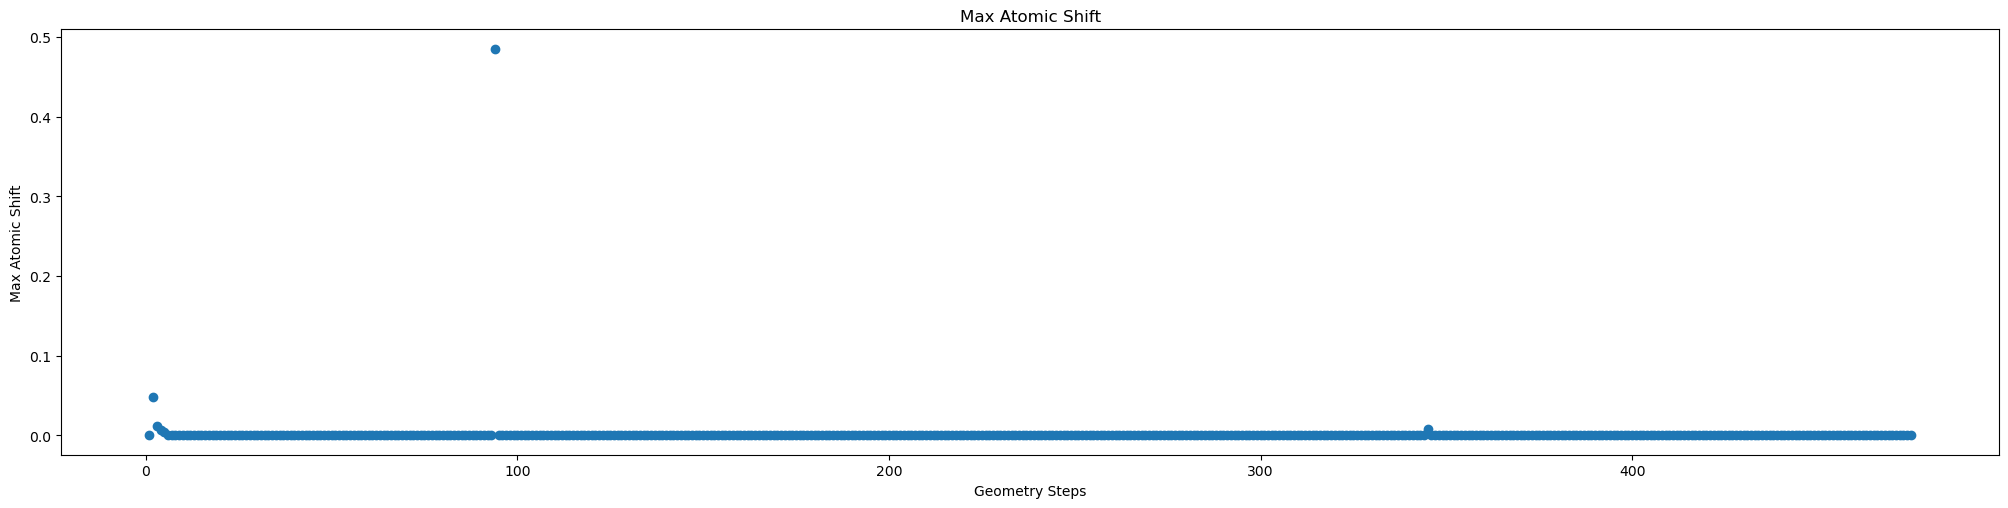

In [14]:
# Calculates max rmsd for each step and plots it against 
readers.unit_cells[0].element_names
length = len(readers.unit_cells[0].element_names)
steps = list(range(1, ((len(readers.unit_cells)))))

max_atomic_shift = []
c2 = 1

while c2 < len(readers.unit_cells):
    c1 = 0
    ss = readers.unit_cells[c2-1].xyz_coordinates
    es = readers.unit_cells[c2].xyz_coordinates
    rmslist =[]
    while c1 < len(ss):
        diff = ss[c1] - es[c1]
        N = len(ss)
        rms = np.sqrt((diff * diff).sum() / N)
        rmslist.append(rms)
        c1+=1
    max_rms = max(rmslist)
    max_atomic_shift.append(max_rms)
    c2+=1
print(max_rms)
print(max_atomic_shift)

import matplotlib.pyplot as plt
cutoff = -1
fig = plt.figure(figsize=(20, 5))
plt.scatter(steps[:cutoff], max_atomic_shift[:cutoff])
plt.title('Max Atomic Shift')
plt.xlabel('Geometry Steps')
plt.ylabel('Max Atomic Shift')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()


In [15]:
import pandas as pd

def make_dfs(names, coords):
    df_list = []
    for i in readers.unit_cells:
        names_df = pd.Series(names, name='Element')
        coords_df = pd.DataFrame(coords)
        labelled_coords_df = coords_df
        labelled_coords_df = labelled_coords_df.rename(columns={0:'x', 1:'y', 2:'z'})
        labelled_coords_df["Element"] = names_df
    
    return coords_df, labelled_coords_df

def rmsd_step(coords_df):
        rms_df = coords_df[step-1] - coords[step]
        N = len(coords_df)
        rms_df[3] = ((((rms_df[0] ** 2) + (rms_df[1] ** 2) + (rms_df[2] ** 2))/ N) ** 0.5)
        
        return coords_df
        

x = make_dfs(readers.unit_cells[0].element_names, readers.unit_cells[0].xyz_coordinates)
y = make_dfs(readers.unit_cells[-1].element_names, readers.unit_cells[-1].xyz_coordinates)

# z = x[0] - y[0]
# q = np.sqrt((z * z).sum() / 96)
# w = pd.Series((z ** 2).sum() ** 0.5)
# z[3] = ((((z[0] ** 2) + (z[1] ** 2) + (z[2] ** 2))/len(z)) ** 0.5)
# z[3]
# for row in z.iterrow():
#     np.sqrt((row * row).sum() / 96)

In [16]:
ss = readers.unit_cells[1].xyz_coordinates
es = readers.unit_cells[2].xyz_coordinates
rmslist =[]

diff = ss[0] - es[0]
N = len(ss)
rms = np.sqrt((diff * diff).sum() / N)
print(diff)
print(rms)
# while c1 < len(ss):
#     diff = ss[c1] - es[c1]
#     N = len(ss)
#     rms = np.sqrt((diff * diff).sum() / N)
#     rmslist.append(rms)
readers.nions

[-0.0093931  -0.45720167 -0.06665887]
0.047166041087538094


96

In [36]:
# This cell removes H values and creates a violin plot of RMSD between starting and final structures of all non H atoms
names = readers.unit_cells[0].element_names
nonH_index = []
rmslist = []
c1 = 0
c2 = 0
for i in names:
    if i != 'H':   
        nonH_index.append(c1)
    c1+=1

ssfull = readers.unit_cells[0].xyz_coordinates
ss = readers.unit_cells[0].xyz_coordinates[nonH_index[0]:nonH_index[-1]+1]
es = readers.unit_cells[-1].xyz_coordinates[nonH_index[0]:nonH_index[-1]+1]

while c2 < len(ss):
        diff = ss[c2] - es[c2]
        N = len(ss)
        rms = np.sqrt((diff * diff).sum() / N)
        rmslist.append(rms)
        c2+=1

nonH_names = names[nonH_index[0]:(nonH_index[-1]+1)]
c3 = 0
nonH_rmsd = []
while c3 < len(rmslist):
    nonH_rmsd.append([nonH_names[c3], rmslist[c3]])
    c3+=1
nonH_names_s = list(dict.fromkeys(nonH_names))
rms_dict = dict.fromkeys(nonH_names_s)

new_dict = {i: [] for i in nonH_names_s}
for i in nonH_rmsd:
    new_dict[i[0]].append(i[1])

dflist = []
for i in nonH_names_s:
    dflist.append(pd.DataFrame(new_dict[i]))


In [39]:
len(rmslist)

48

In [19]:
readers.unit_cells[0].xyz_coordinates[79]

array([ 4.56240716, 13.5919554 ,  0.72014168])

In [20]:
readers.unit_cells[-1].xyz_coordinates[79]

array([ 4.58232634, 13.86811613,  0.6326752 ])

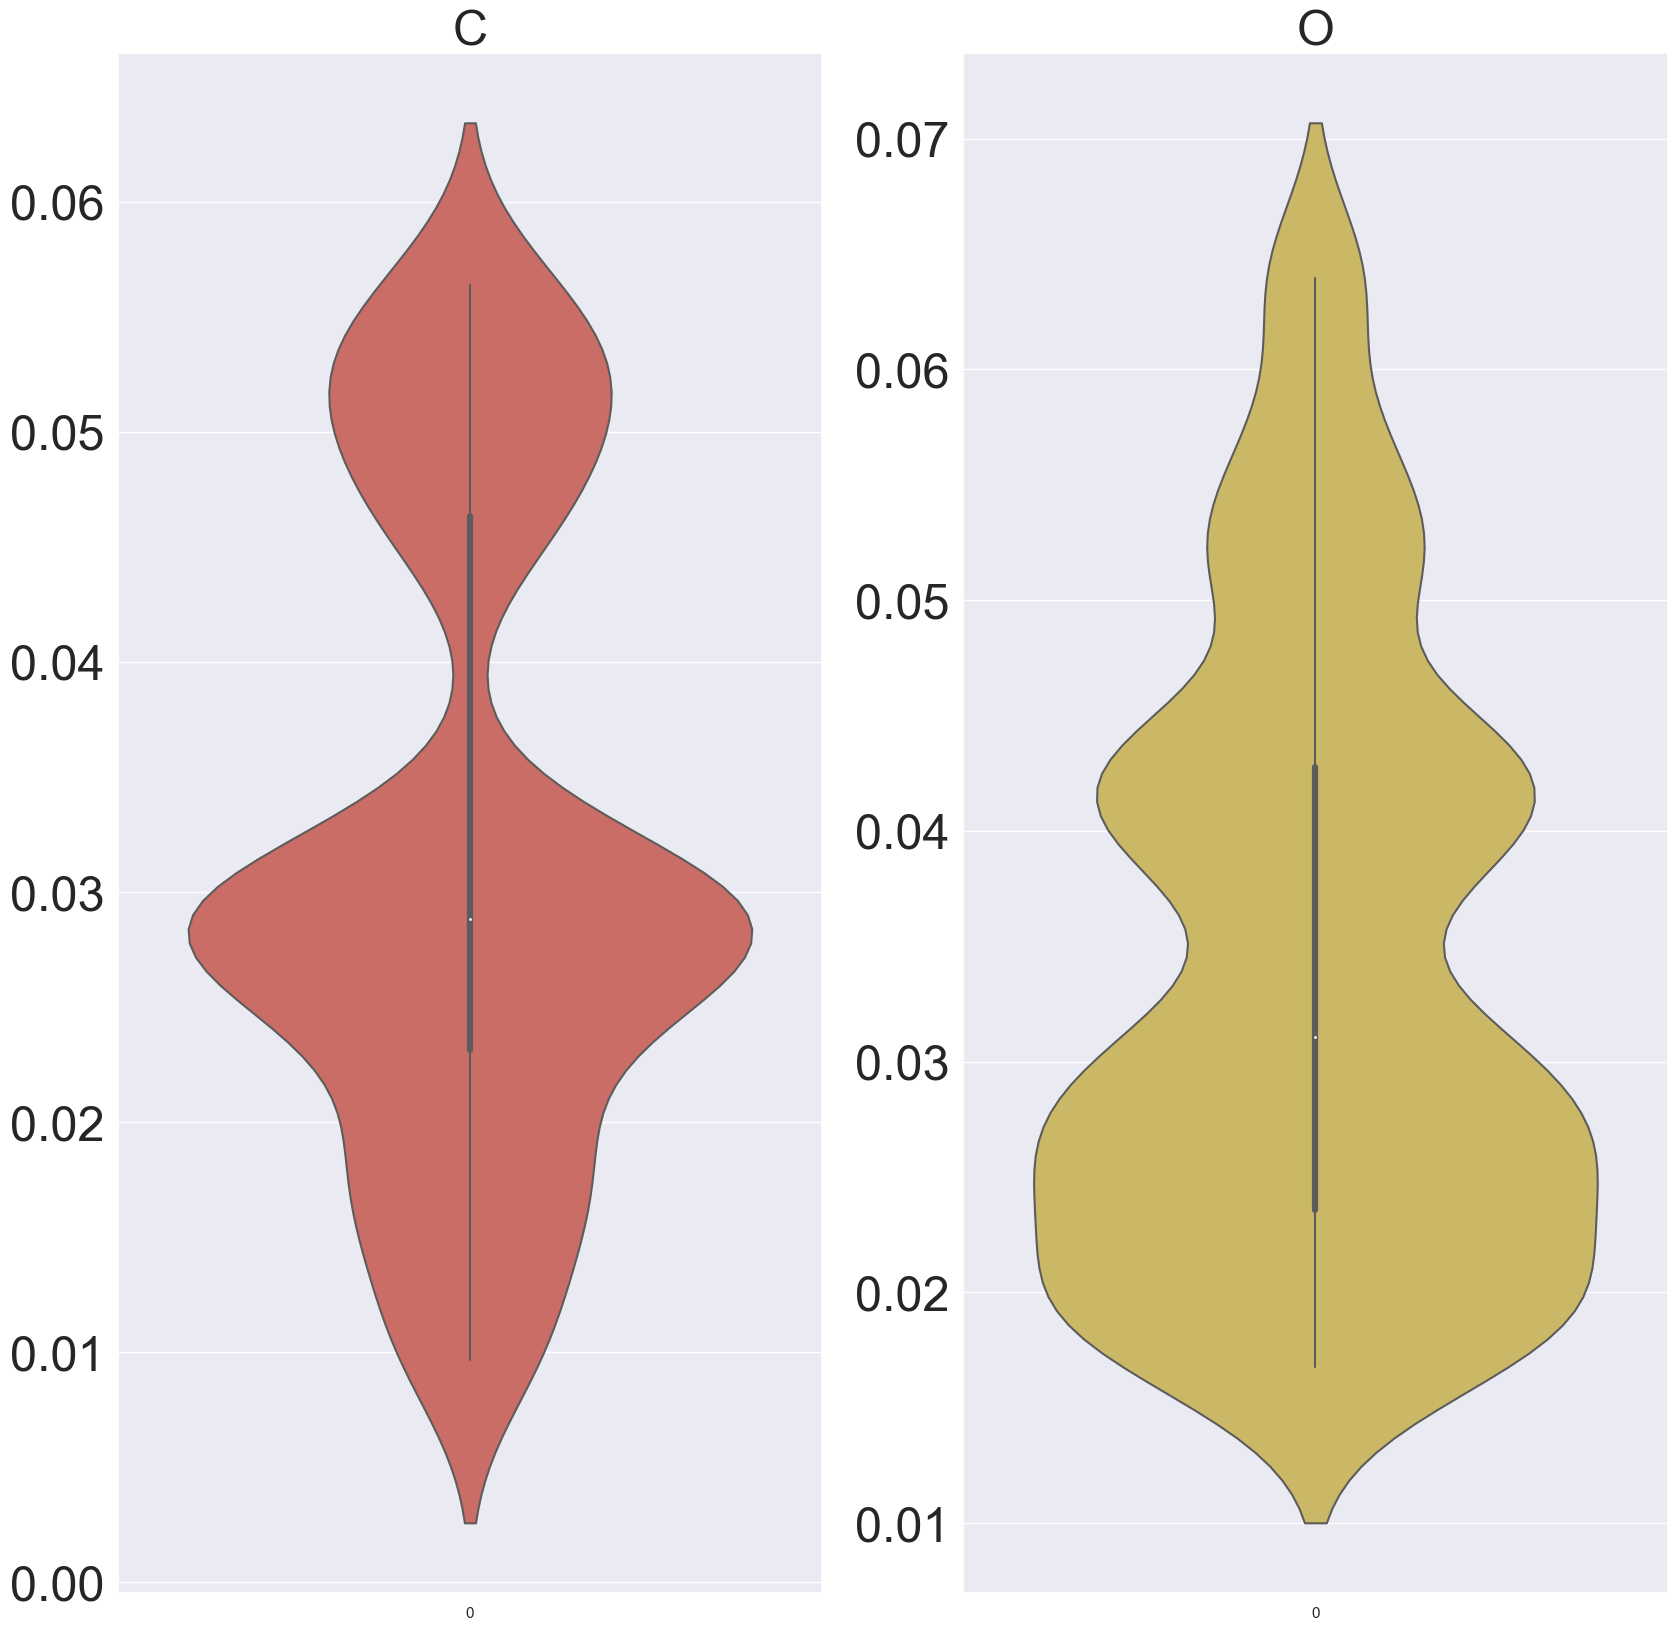

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

sns.set(rc={"font.size":35,"axes.titlesize":35,"axes.labelsize":35, "ytick.labelsize":35})
palette = cycle(sns.color_palette("hls", 8))

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
# print(dflist[1])
c1 = 0
for i in dflist: 
    sns.violinplot(data=i, ax=ax.flat[c1], bw=0.25, color=next(palette)).set_title(nonH_names_s[c1])
    c1+=1

plt.show()

In [22]:
ax = sns.violinplot(hue="smoker", data=dflist, palette="muted")

ValueError: Cannot use `hue` without `x` and `y`

In [24]:
print(len(dflist[]))

23


In [23]:
# x = np.array(Moleculesdf_start.at[0,"Molecules"][0])
# y = np.array(Moleculesdf_start.at[0,"Molecules"][0])
# z = Moleculesdf_start.at[0,"Molecules"][4]
# print(z)
# # Convert object to str for parsing
# string = str(z)
# # Split string into list
# list1 = string.split()
# print(list1)
# #list contains brackets in different places depending on whether first coord is negative. This removes them and creates one list
# if list1[0] ==  '[':
#     newlist = list1[1:4]
#     newlist.append(list1[4])
# #     print(newlist)
#     nobrak = newlist[2].split(']')
#     newlist[2] = nobrak[0]
# else:
#     newlist = list1[0:3]
#     newlist.append(list[3])
# #     print(newlist)
#     nobrak = newlist[0].split('[')
#     newlist[0] = nobrak[1]
#     nobrak = newlist[2].split(']')
#     newlist[2] = nobrak[0]

# print(newlist)

 labelled_xyz_df = pd.DataFrame(readers.unit_cells[step].xyz_coordinates, columns= ['x','y','z'])
    labelled_xyz_df['Element'] = readers.unit_cells[step].element_names
    labelled_xyz_df

IndentationError: unexpected indent (<ipython-input-23-4e8fd9d6d806>, line 28)

In [ ]:
def make_df(step):
    
    labelled_xyz_df = pd.DataFrame(readers.unit_cells[step].xyz_coordinates, columns= ['x','y','z'])
    labelled_xyz_df['Element'] = readers.unit_cells[step].element_names
    labelled_xyz_df
    
    return(labelled_xyz_df)

def rms(start,end):
    c1 = 0
    rmslist = []
    while c1 < len(start):
        diff = start[c1] - end[c1]
        N = len(start)
        rms = np.sqrt((diff * diff).sum() / N)
        rmslist.append(rms)
        c1 += 1
    
    return rmslist

In [ ]:
x = make_df(-1)
x.loc[1][0]

In [ ]:
ss = readers.unit_cells[0].xyz_coordinates
es = readers.unit_cells[-1].xyz_coordinates
rmslist = rms(ss,es)
rmsdf = pd.DataFrame(rmslist)
rmsdf['Element'] = readers.unit_cells[0].element_names
# rmsdf.to_excel('RMS.xlsx')

## Hungarian + Molecule Matcher 

In [ ]:
import os
import dill as pickle
from PDielec.Constants import covalent_radii
from pymatgen.io.ase import AseAtomsAdaptor
import pandas as pd
from pymatgen.core import Lattice, Structure, Molecule

In [ ]:
picklefile = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\IVDWFiles\\D3BJ\\D3BJ_cat.pickle'
# print(cwd)

# This opens the pickled file generated by preader, 
# should read in multiple files if preader prcoessed multiple output files at once 
readers = []   
with open(picklefile,'rb') as f:
     readers = pickle.load(f)

In [ ]:
# This cell produces pymatgen.site objects in a dataframe for the start and end structures

start_end_list = [0, -1 ]
for k in start_end_list:
    if k == 0:
        oldcell = readers.unit_cells[0]
    else:
        oldcell = readers.unit_cells[-1]
    atom_masses = readers.masses
    oldcell.set_atomic_masses(atom_masses)
    bond_scale = 1.1
    tolerance = 0.1

    newcell, nmols, temp = oldcell.calculate_molecular_contents(bond_scale, tolerance, covalent_radii)

    #     print(nmols)

    newcell.cartesian_coordinates = newcell.convert_abc_to_xyz(newcell.fractional_coordinates)

    if k == 0:
        data_start = {"Molecules":[],"Atoms":[]};
        for i in range(nmols):
            elements = [newcell.element_names[j] for j in newcell.molecules[i]]
            positions = [newcell.cartesian_coordinates[j] for j in newcell.molecules[i]]
            molecule = Molecule(elements, positions)
            atom = AseAtomsAdaptor.get_atoms(molecule)
            data_start["Molecules"].append(molecule)
            data_start["Atoms"].append(atom)
        Moleculesdf = pd.DataFrame(data_start)

    else:
        data_end = {"Molecules":[],"Atoms":[]};
        for i in range(nmols):
            elements = [newcell.element_names[j] for j in newcell.molecules[i]]
            positions = [newcell.cartesian_coordinates[j] for j in newcell.molecules[i]]
            molecule = Molecule(elements, positions)
            atom = AseAtomsAdaptor.get_atoms(molecule)
            data_end["Molecules"].append(molecule)
            data_end["Atoms"].append(atom)
        Moleculesdf_end = pd.DataFrame(data_end)



In [ ]:
from pymatgen.analysis.molecule_matcher import MoleculeMatcher, HungarianOrderMatcher
molecule = 1
m = MoleculeMatcher()
p = HungarianOrderMatcher(Moleculesdf.at[molecule,"Molecules"])


print(m.fit(Moleculesdf.at[molecule,"Molecules"], Moleculesdf_end.at[molecule,"Molecules"]))
print(m.get_rmsd(Moleculesdf.at[molecule,"Molecules"], Moleculesdf_end.at[molecule,"Molecules"]))

temp = p.fit(Moleculesdf_end.at[molecule,"Molecules"])
print(m.fit(Moleculesdf.at[molecule,"Molecules"], temp[0]))
print(temp[1])

# Both molecules have very similar values within the unit cell

In [ ]:
print(temp[1])
print(temp[0])

In [ ]:
readers.unit_cells[0].volume